In [388]:
%load_ext autoreload
%autoreload 2
from configs import project_config
import pickle
import numpy as np
import torch
import os
from src.generative_modelling.models.ClassVPSDEDiffusion import VPSDEDiffusion
import matplotlib.pyplot as plt
from configs.RecursiveVPSDE.LSTM_fBiPot.recursive_LSTM_PostMeanScore_fBiPot_T256_H05_tl_110data_SbleTgt_WRMSE import get_config as get_config
from configs.RecursiveVPSDE.LSTM_fBiPot.recursive_LSTM_PostMeanScore_fBiPot_T256_H05_tl_110data_WRMSE import get_config as get_config
from configs.RecursiveVPSDE.LSTM_fQuadSinHF.recursive_LSTM_PostMeanScore_fQuadSinHF_T256_H05_tl_110data_WRMSE import get_config as get_config

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [389]:
def rmse_ignore_nans(y_true, y_pred):
    assert (y_true.shape[0] == y_pred.shape[0])
    y_true = y_true.flatten()
    y_pred = y_pred.flatten()
    mask = ~np.isnan(y_true) & ~np.isnan(y_pred)  # Ignore NaNs in both arrays
    return np.sqrt(np.mean((y_true[mask] - y_pred[mask]) ** 2))

def plot_drift_estimator(mean, mean_min, mean_max, numpy_Xs, true_drift, ts_type,Nepoch,toSave:bool = True):
    fig, ax = plt.subplots(figsize=(14,9))
    rmse = rmse_ignore_nans(true_drift, mean).astype(np.float64)#np.power(np.mean(np.power(true_drift - mean, 2)), 0.5)
    ax.scatter(numpy_Xs, true_drift, color="red", label="True Drift")
    plt.errorbar(numpy_Xs,mean,yerr=[mean-mean_min, mean_max-mean],xerr=None, fmt='o', color="blue", alpha=0.4)
    plt.scatter(numpy_Xs, mean, label="Estimated Drift", color="blue")
    ax.set_title(rf"RMSE {round(rmse,3)} for LSTM Score Estimator", fontsize=40)
    ax.tick_params(labelsize=38)
    ax.set_xlabel("State $X$", fontsize=38)
    ax.set_ylabel("Drift Value", fontsize=38)
    ax.legend(fontsize=24)
    plt.tight_layout()
    if toSave:
        plt.savefig(f"/Users/marcos/Library/CloudStorage/OneDrive-ImperialCollegeLondon/StatML_CDT/Year2/DiffusionModelPresentationImages/{ts_type}_LSTM_{Nepoch}Nep_{config.deltaT:.3e}dT_{config.loss_factor}LFac.png",  bbox_inches='tight')
    plt.show()
    plt.close()

In [390]:
config = get_config()
print(config.beta_min)
if config.has_cuda:
    device = int(os.environ["LOCAL_RANK"])
else:
    print("Using CPU\n")
    device = torch.device("cpu")

diffusion = VPSDEDiffusion(beta_max=config.beta_max, beta_min=config.beta_min)

max_diff_steps = config.max_diff_steps
sample_eps = config.sample_eps
ts_step = 1 / config.ts_length

0.0
Using CPU



In [391]:
def get_drift_files(config, ts_type_str):
    ts_type = f"{ts_type_str}"
    if "BiPot" in ts_type_str:
        include =  (f"{config.deltaT:.3e}dT_{config.quartic_coeff}a_{config.quad_coeff}b_{config.const}c_{config.residual_layers}ResLay_{config.loss_factor}LFac").replace(
                    ".", "")
    elif "QuadSin" in ts_type_str:
        include = (f"{config.deltaT:.3e}dT_{config.quad_coeff}a_{config.sin_coeff}b_{config.sin_space_scale}c_{config.residual_layers}ResLay_{config.loss_factor}LFac").replace(
                ".", "")
    root_dir = project_config.ROOT_DIR + f"experiments/results/"
    driftevalexp_files = []
    driftoostrack_true_files = []
    driftoostrack_local_files = []
    for file in os.listdir(root_dir):
        if "LSTM" in file and ts_type in file and include in file:
            if (("ST" in ts_type_str and "_ST_" in file) or (("ST" not in ts_type_str and "_ST_" not in file))):
                if "muhats" in file and "DriftEvalExp" in file:
                    driftevalexp_files.append(root_dir+file)
                elif "OOSDriftTrack" in file and "true" in file:
                    driftoostrack_true_files.append(root_dir+file)
                elif "OOSDriftTrack" in file and "local" in file:
                    driftoostrack_local_files.append(root_dir+file)
    assert len(driftoostrack_true_files)>0, "No oos drift track files found"
    assert len(driftoostrack_local_files)>0, "No oos drift track files found"
    assert len(driftevalexp_files)>0, "No eval exp files found"
    def extract_bw_drift_eval_exp_number(s):
        match = s.split("Nep_")[0].split("_")[-1]
        return int(match)
    def extract_bw_drift_track_number(s):
        match = s.split("Nep_")[0].split("_")[-1]
        return int(match)
    driftevalexp_files = sorted(driftevalexp_files, key=extract_bw_drift_eval_exp_number)
    driftoostrack_true_files = sorted(driftoostrack_true_files, key=extract_bw_drift_track_number)
    driftoostrack_local_files = sorted(driftoostrack_local_files, key=extract_bw_drift_track_number)
    Nepochs_track = [extract_bw_drift_track_number(f) for f in driftoostrack_true_files]
    Nepochs_drifteval = [extract_bw_drift_eval_exp_number(f) for f in driftevalexp_files]
    return driftevalexp_files, driftoostrack_true_files, driftoostrack_local_files, Nepochs_track, Nepochs_drifteval

In [392]:
if "BiPot" in config.data_path:
    if "_ST_" in config.scoreNet_trained_path:
        ts_type_str = "ST_fBiPot"
    else:
        ts_type_str = "fBiPot"
elif "QuadSinHF" in config.data_path:
    ts_type_str = "fQuadSinHF"
print(ts_type_str)
driftevalexp_files, driftoostrack_true_files, driftoostrack_local_files, Nepochs_track, Nepochs_drifteval = get_drift_files(config=config, ts_type_str=ts_type_str)

fQuadSinHF


In [393]:
eval_exp_rmses = {}
for f in zip(*[Nepochs_drifteval, driftevalexp_files]):
    Nepoch = f[0]
    file = f[1]
    try:
        if Nepoch > 18190: raise FileNotFoundError
        muhats = torch.Tensor(np.load(file))
        Xshape = muhats.shape[0]
        Xs = torch.Tensor(np.linspace(-1.5,1.5,Xshape))#np.load(file_path+"numpyXs.npy"))
        if "BiPot" in config.data_path:
            true_drifts = -(4.*config.quartic_coeff * np.power(Xs, 3) + 2.*config.quad_coeff * Xs + config.const).numpy()
        elif "QuadSin" in config.data_path:
            true_drifts = (-2. * config.quad_coeff * Xs + config.sin_coeff * config.sin_space_scale * np.sin(
        config.sin_space_scale * Xs)).numpy()
        mu_hats = muhats[:, -1, :].reshape(muhats.shape[0], muhats.shape[-1]*1).mean(dim=-1).numpy()
        rmse = rmse_ignore_nans(true_drifts, mu_hats).astype(np.float64)
        eval_exp_rmses.update({Nepoch: round(rmse, 4)})
    except FileNotFoundError as e:
        print(e)
        continue
eval_exp_rmses

{4: 1.1362,
 6: 0.8915,
 8: 0.7556,
 10: 0.7539,
 12: 0.7356,
 14: 0.7517,
 16: 0.7513,
 18: 0.7575,
 20: 0.742,
 22: 0.744,
 24: 0.7405,
 26: 0.7172,
 28: 0.7249,
 30: 0.7223,
 32: 0.7515,
 34: 0.7644,
 36: 0.717,
 38: 0.7145,
 40: 0.715,
 42: 0.7136,
 44: 0.7223,
 46: 0.7163,
 48: 0.7466,
 50: 0.7591,
 52: 0.7638,
 54: 0.7127,
 56: 0.7111,
 58: 0.7198,
 60: 0.7603,
 62: 0.7112,
 64: 0.7098,
 66: 0.7988,
 68: 0.7295,
 70: 0.7792,
 72: 0.7093,
 74: 0.7134,
 76: 0.7132,
 78: 0.7289,
 80: 0.7137,
 82: 0.7285,
 84: 0.7357,
 86: 0.766,
 88: 0.7063,
 90: 0.7445,
 92: 0.7775,
 94: 0.7319,
 96: 0.7133,
 98: 0.7136,
 100: 0.7193,
 102: 0.7235,
 104: 0.7138,
 106: 0.7295,
 108: 0.7737,
 110: 0.7744,
 112: 0.7139,
 114: 0.7212,
 116: 0.7346,
 118: 0.7128,
 120: 0.721,
 122: 0.8103,
 124: 0.7269,
 126: 0.7101,
 128: 0.8081,
 130: 0.7319,
 132: 0.7769,
 134: 0.7383,
 136: 0.7205,
 138: 0.7236,
 140: 0.8056,
 142: 0.7487,
 144: 0.7522,
 146: 0.7072,
 148: 0.7212,
 150: 0.7129,
 152: 0.7205,
 154: 0

In [394]:
drift_track_rmses = {}
for f in zip(*[Nepochs_track, driftoostrack_true_files, driftoostrack_local_files]):
    Nepoch = f[0]
    true = f[1]
    local = f[2]
    try:
        all_true_states = np.load(true)/np.sqrt(config.deltaT)
        all_local_states= np.load(local)/np.sqrt(config.deltaT)
        all_local_errors = np.cumsum(np.mean(np.power(all_true_states- all_local_states,2), axis=(1,3)), axis=-1)/np.arange(1, all_local_states.shape[2]+1)
        total_local_errors = np.mean(np.sqrt(all_local_errors), axis=0)
        drift_track_rmses.update({Nepoch:total_local_errors[-1]})
    except FileNotFoundError as e:
        print(e)
        continue
drift_track_rmses

{4: 0.0501519634333026,
 6: 0.0457924601845653,
 8: 0.04460575808298385,
 10: 0.045188300734807965,
 12: 0.044014471166182643,
 14: 0.04496871683251609,
 16: 0.04535110543453981,
 18: 0.046010852657983284,
 20: 0.04507311951678239,
 22: 0.045125850958146786,
 24: 0.044579251776032155,
 26: 0.0436836197993632,
 28: 0.04380050064986392,
 30: 0.04403905121646859,
 32: 0.04565749021631467,
 34: 0.046362344658524866,
 36: 0.04390626189883347,
 38: 0.04366707425072275,
 40: 0.043731243017105806,
 42: 0.04373706570442726,
 44: 0.04435783419460743,
 46: 0.04418603484484001,
 48: 0.04556188602675164,
 50: 0.046465357300871694,
 52: 0.04652685521371468,
 54: 0.04381386162772283,
 56: 0.04363429888232705,
 58: 0.04412281214972962,
 60: 0.046424863503614605,
 62: 0.04404945039279312,
 64: 0.043548370864790846,
 66: 0.0485303401947066,
 68: 0.044919209634927786,
 70: 0.047376812979571394,
 72: 0.043852998473301714,
 74: 0.04356637936523723,
 76: 0.043686771793516085,
 78: 0.04498180641298062,
 80: 

In [395]:
with open(config.scoreNet_trained_path.replace("/trained_models/", "/training_losses/") + "_loss", 'rb') as f:
        losses = np.sqrt(np.array(pickle.load(f)).astype(float))
Nepochs_losses = np.arange(losses.shape[0])

In [400]:
common_epochs = np.intersect1d(np.intersect1d(Nepochs_losses, Nepochs_track), Nepochs_drifteval)
common_epochs = common_epochs[np.array([(10<=c<=960) for c in common_epochs])]
start_idx = 0
common_epochs = common_epochs[start_idx:]
losses_idx = [np.argwhere(c == Nepochs_losses)[0,0] for c in common_epochs]
track_idx = [np.argwhere(c == Nepochs_track)[0,0] for c in common_epochs]
evalexp_idx = [np.argwhere(c == Nepochs_drifteval)[0,0] for c in common_epochs]
red_losses = losses[losses_idx]
eval_rmses = np.array(list(eval_exp_rmses.values()))[evalexp_idx]
track_rmses = np.array(list(drift_track_rmses.values()))[track_idx]

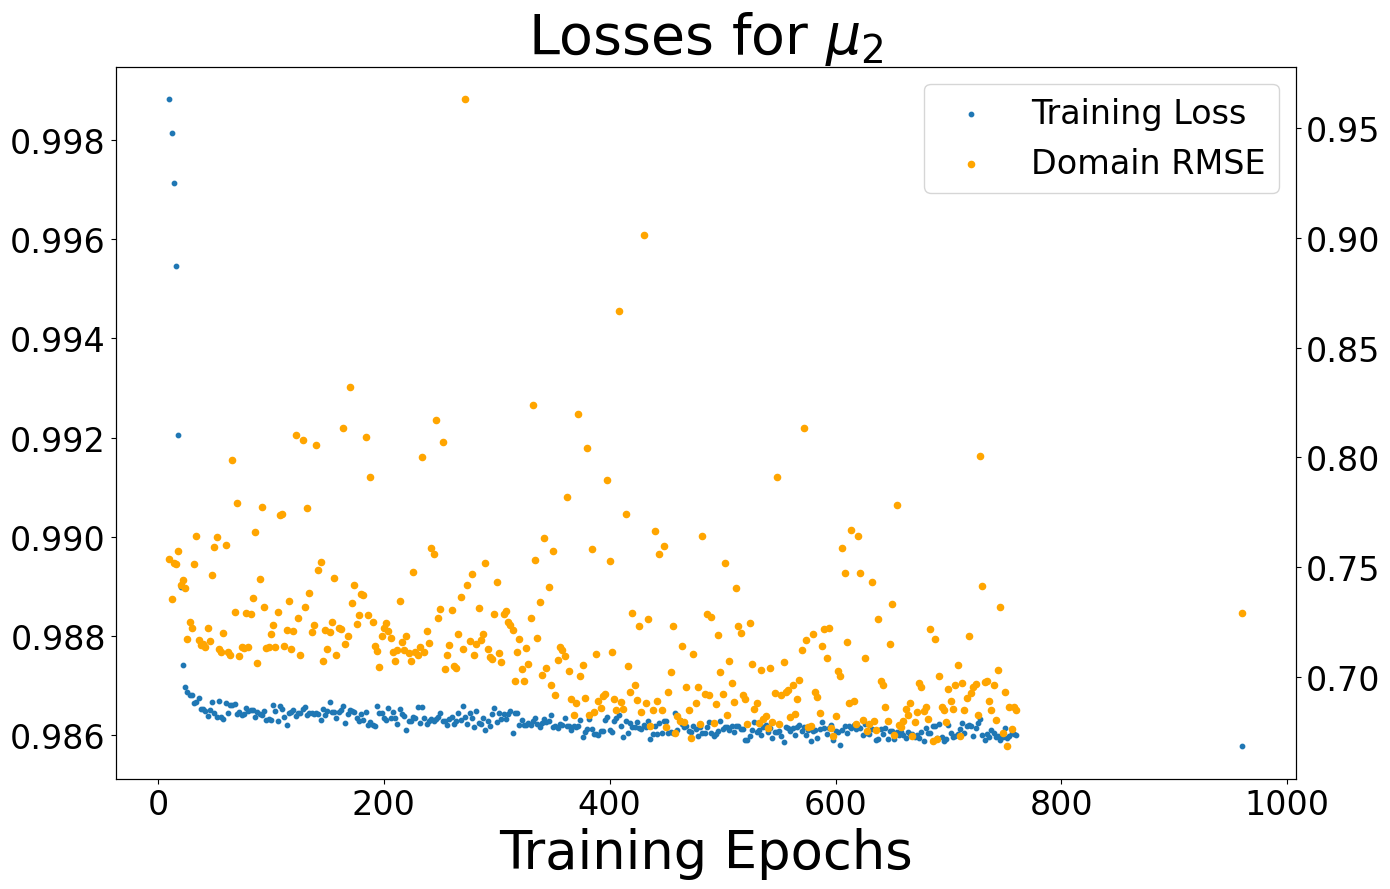

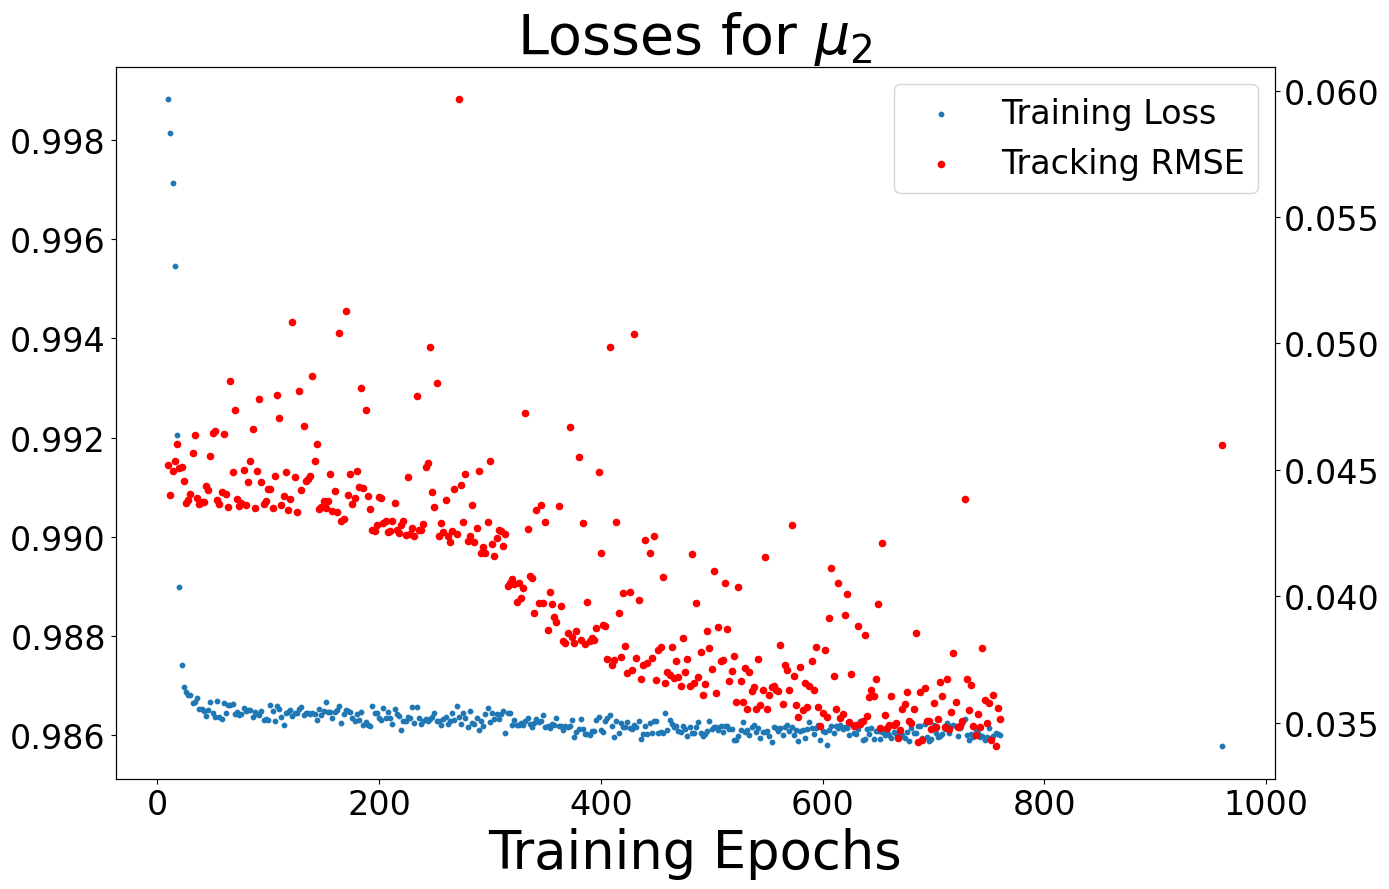

In [401]:
toSave = True
fig, ax = plt.subplots(figsize=(14,9))
sc1 = ax.scatter(common_epochs, red_losses, s=10, label="Training Loss")
ax.tick_params(axis="both",labelsize=24)
ax2 = ax.twinx()
sc2 = ax2.scatter(common_epochs, eval_rmses, s=20, color="orange",label="Domain RMSE")
ax.set_xlabel("Training Epochs", fontsize=38)
if "BiPot" in config.data_path:
    if "_ST_" in config.scoreNet_trained_path:
        ax.set_title(r"Losses for StableTarget $\mu_{3}$", fontsize=40)
    else:
        ax.set_title(r"Losses for $\mu_{3}$", fontsize=40)
elif "QuadSinHF" in config.data_path:
    if "004b" in config.data_path:
        ax.set_title(r"Losses for $\mu_{2}$", fontsize=40)
    else:
        ax.set_title(r"Losses for $\mu_{1}$", fontsize=40)
ax.tick_params(axis="both",labelsize=24)
ax2.tick_params(axis="both",labelsize=24)
plt.tight_layout()
handles = [sc1, sc2]
labels = [h.get_label() for h in handles]
# Add a single legend on ax1
ax.legend(handles, labels, fontsize=24)
if toSave:
    if "BiPot" in config.data_path:
        plt.savefig((f"/Users/marcos/Library/CloudStorage/OneDrive-ImperialCollegeLondon/StatML_CDT/Year2/DiffusionModelPresentationImages/{ts_type_str}_LossesEval_PM_LSTM_{config.deltaT:.3e}dT_{config.loss_factor}LFac").replace(".","")+".png",  bbox_inches='tight')
    elif "QuadSinHF" in config.data_path:
        if "004b" in config.data_path:
            plt.savefig((f"/Users/marcos/Library/CloudStorage/OneDrive-ImperialCollegeLondon/StatML_CDT/Year2/DiffusionModelPresentationImages/{ts_type_str}2_LossesEval_PM_LSTM_{config.deltaT:.3e}dT_{config.loss_factor}LFac").replace(".","")+".png",  bbox_inches='tight')
        else:
            plt.savefig((f"/Users/marcos/Library/CloudStorage/OneDrive-ImperialCollegeLondon/StatML_CDT/Year2/DiffusionModelPresentationImages/{ts_type_str}1_LossesEval_PM_LSTM_{config.deltaT:.3e}dT_{config.loss_factor}LFac").replace(".","")+".png",  bbox_inches='tight')
plt.show()
plt.close()
fig, ax = plt.subplots(figsize=(14,9))
sc1 = ax.scatter(common_epochs, red_losses, s=10, label="Training Loss")
ax2 = ax.twinx()
sc2 = ax2.scatter(common_epochs, track_rmses, s=20, color="red",label="Tracking RMSE")
ax.set_xlabel("Training Epochs", fontsize=38)
if "BiPot" in config.data_path:
    if "_ST_" in config.scoreNet_trained_path:
        ax.set_title(r"Losses for StableTarget $\mu_{3}$", fontsize=40)
    else:
        ax.set_title(r"Losses for $\mu_{3}$", fontsize=40)
elif "QuadSinHF" in config.data_path:
    if "004b" in config.data_path:
        ax.set_title(r"Losses for $\mu_{2}$", fontsize=40)
    else:
        ax.set_title(r"Losses for $\mu_{1}$", fontsize=40)
ax.tick_params(axis="both",labelsize=24)
ax2.tick_params(axis="both",labelsize=24)
plt.tight_layout()
handles = [sc1, sc2]
labels = [h.get_label() for h in handles]
# Add a single legend on ax1
ax.legend(handles, labels, fontsize=24)
if toSave:
    if "BiPot" in config.data_path:
        plt.savefig((f"/Users/marcos/Library/CloudStorage/OneDrive-ImperialCollegeLondon/StatML_CDT/Year2/DiffusionModelPresentationImages/{ts_type_str}_LossesTrack_PM_LSTM_{config.deltaT:.3e}dT_{config.loss_factor}LFac").replace(".","")+".png",  bbox_inches='tight')
    elif "QuadSinHF" in config.data_path:
        if "004b" in config.data_path:
            plt.savefig((f"/Users/marcos/Library/CloudStorage/OneDrive-ImperialCollegeLondon/StatML_CDT/Year2/DiffusionModelPresentationImages/{ts_type_str}2_LossesTrack_PM_LSTM_{config.deltaT:.3e}dT_{config.loss_factor}LFac").replace(".","")+".png",  bbox_inches='tight')
        else:
            plt.savefig((f"/Users/marcos/Library/CloudStorage/OneDrive-ImperialCollegeLondon/StatML_CDT/Year2/DiffusionModelPresentationImages/{ts_type_str}1_LossesTrack_PM_LSTM_{config.deltaT:.3e}dT_{config.loss_factor}LFac").replace(".","")+".png",  bbox_inches='tight')
plt.show()
plt.close()

In [402]:
df = pd.DataFrame([eval_rmses, track_rmses], columns=common_epochs, index=["DomainRMSE", "TrackRMSE"])
df.T.describe()

,DomainRMSE,TrackRMSE
count,377.000000,377.000000
mean,0.717544,0.040463
std,0.036672,0.004156
min,0.668300,0.034066
25%,0.690800,0.036640
50%,0.712200,0.040378
75%,0.729300,0.043690
max,0.963200,0.059655


In [403]:
raise RuntimeError

RuntimeError: 

In [ ]:
from configs.RecursiveVPSDE.LSTM_fBiPot.recursive_LSTM_PostMeanScore_fBiPot_T256_H05_tl_110data_SbleTgt import get_config as get_config
gconfig2 = get_config()
with open(gconfig2.scoreNet_trained_path.replace("/trained_models/", "/training_losses/") + "_loss", 'rb') as f:
        print(f)
        losses2 = np.array(pickle.load(f))[:losses.shape[0]]
plt.scatter(np.arange(start_idx, losses2.shape[0]), losses2[start_idx:],s=2, label="Stable Target")
#plt.hlines(np.sqrt(config.deltaT), xmin = start_idx, xmax=losses.shape[0]-start_idx, color="red")
plt.yscale("log")
plt.legend()
losses2[-1]/losses2[start_idx]

In [ ]:
start_idx = 00
def compute_ema(loss_tensor, beta):
    ema_values = np.zeros_like(loss_tensor)  # Initialize EMA tensor
    ema_values[0] = loss_tensor[0]  # First value stays the same

    for i in range(1, len(loss_tensor)):
        ema_values[i] = beta * ema_values[i - 1] + (1 - beta) * loss_tensor[i]

    return ema_values
# Define EMA decay rates
beta_short = 0.9   # Short-term trend (reacts quickly)
beta_long = 0.99   # Long-term trend (smoother)

# Compute EMAs
short_term_ema = compute_ema(losses, beta_short)
long_term_ema = compute_ema(losses, beta_long)
plt.scatter(np.arange(start_idx, short_term_ema.shape[0]), (short_term_ema[start_idx:]),s=2, label="Short Term Loss")
plt.yscale("log")
plt.legend()
plt.show()
plt.scatter(np.arange(start_idx, long_term_ema.shape[0]), (long_term_ema[start_idx:]),s=2, label="Long Term Loss")
plt.yscale("log")
plt.legend()
plt.show()

In [ ]:
best_rmse = np.inf
toSave = False
for Nepoch in config.max_epochs:
    try:
        Ndiff = config.max_diff_steps
        if "PMS" in config.scoreNet_trained_path:
            type = "PMS"
        elif "PM" in config.scoreNet_trained_path:
            type = "PM"
        else:
            type = ""

        if "fSin" in config.data_path:
            file_path = f"/Users/marcos/GitHubRepos/FractionalBrownianMotion/experiments/results/TS{type}_LSTM_fSin_DriftEvalExp_{Nepoch}Nep_{config.loss_factor}LFactor_10MeanRev_{Ndiff}DiffSteps_"
        elif "fQuadSinHF" in config.data_path:
            file_path = (project_config.ROOT_DIR + f"experiments/results/TSPM_LSTM_fQuadSinHF_DriftEvalExp_{Nepoch}Nep_{config.t0}t0_{config.deltaT:.3e}dT_{config.quad_coeff}a_{config.sin_coeff}b_{config.sin_space_scale}c_{config.residual_layers}ResLay_{config.loss_factor}LFac_").replace(
                            ".", "")
            print(file_path)
        elif "fBiPotSmall" in config.data_path:
            file_path = (
                    project_config.ROOT_DIR + f"experiments/results/TS{type}_LSTM_fBiPotSmall_DriftEvalExp_{Nepoch}Nep_{config.loss_factor}LFactor_{config.quartic_coeff}a_{config.quad_coeff}b_{config.const}c_{config.max_diff_steps}DiffSteps_").replace(
                ".", "")
        elif "fBiPot" in config.data_path:
            file_path = (
                        project_config.ROOT_DIR + f"experiments/results/TS{type}_LSTM_fBiPot_DriftEvalExp_{Nepoch}Nep_{config.t0}t0_{config.deltaT:.3e}dT_{config.quartic_coeff}a_{config.quad_coeff}b_{config.const}c_{config.residual_layers}ResLay_{config.loss_factor}LFac_").replace(
                    ".", "")
        muhats = torch.Tensor(np.load(file_path+"muhats.npy"))
        Xshape = muhats.shape[0]
        if "fQuadSinHF" in config.data_path:
            if config.deltaT > 1/(32*256):
                Xs = torch.linspace(-1.5, 1.5, steps=Xshape)
            else:
                Xs = torch.linspace(-.4, .4, steps=Xshape)
            ts_type = "fQuadSinHF"
        elif "fSin" in config.data_path:
            Xs = torch.Tensor(np.linspace(-3,3,Xshape))#np.load(file_path+"numpyXs.npy"))
            ts_type = "fSin"
        elif "fBiPotSmall" in config.data_path:
            Xs = torch.Tensor(np.linspace(-1.5,1.5,Xshape))#np.load(file_path+"numpyXs.npy"))
            ts_type="fBiPotSmall"
        elif "fBiPot" in config.data_path:
            Xs = torch.Tensor(np.linspace(-1.5,1.5,Xshape))#np.load(file_path+"numpyXs.npy"))
            ts_type="fBiPot"
        if type == "":
            type="Standard"
        print(type, ts_type, Ndiff, muhats.shape)
        assert (config.max_diff_steps == 10000)
        if "fQuadSin" in config.data_path:
            true_drifts = -2.*config.quad_coeff * Xs.unsqueeze(-1) + config.sin_coeff * config.sin_space_scale*np.sin(config.sin_space_scale*Xs).unsqueeze(-1)
            print(config.quad_coeff, config.sin_coeff, config.sin_space_scale)
        elif "fSin" in config.data_path:
            true_drifts = config.mean_rev*np.sin(1*Xs).unsqueeze(-1)
        elif "BiPot" in config.data_path:
            true_drifts = -(4.*config.quartic_coeff * np.power(Xs, 3) + 2.*config.quad_coeff * Xs + config.const).unsqueeze(-1)
            #true_drifts = true_drifts/(1.+config.deltaT*torch.abs(true_drifts))
        muhats =  muhats[:, -1, :].reshape(muhats.shape[0], muhats.shape[-1]*1)
        mu_hats = muhats.mean(dim=-1).numpy() # Pointwise drift estimate
        mu_hats_minq = muhats.quantile(dim=-1, q=0.025).numpy() # Lower bound
        mu_hats_maxq = muhats.quantile(dim=-1, q=0.975).numpy() # Lower bound
        print(mu_hats_minq, mu_hats_maxq)
        stds = muhats.std(dim=-1).numpy()
        rmse = rmse_ignore_nans(true_drifts.numpy(), mu_hats).astype(np.float64)#np.power(np.mean(np.power(true_drift - mean, 2)), 0.5)
        if rmse < best_rmse:
            best_rmse = rmse
            plot_drift_estimator(mean=mu_hats, mean_min=mu_hats_minq, mean_max=mu_hats_maxq, numpy_Xs=Xs.numpy(),  toSave=toSave, true_drift=true_drifts.numpy(), ts_type=ts_type, Nepoch=Nepoch)
        print(f"Epoch {Nepoch} done with Best RMSE {best_rmse}\n\n\n\n")
        del muhats, mu_hats, stds, true_drifts
    except FileNotFoundError as e:
        print(e)
        continue